In [1]:
import sys
import os.path
# Addition to path to unlock relative import to the madhatter package
sys.path.append(os.path.abspath(os.path.pardir))

from madhatter import *
from madhatter.loaders import *

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from multiprocess.pool import Pool
# A progress bar to try to give an overall idea of the progress made.
from tqdm import tqdm
import pickle
from pathlib import Path

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from IPython.display import display

input_length = 100_000

print_latex = False


In [2]:
# nlp = spacy.load("en_core_web_sm", disable=[
#                  "ner",
#                  #  "lemmatizer",
#                  "textcat", "attribute_ruler"])
# nlp.pipe_names


def read_texts(path: Path | str, length: int = 1_000_000) -> list[str]:
    """Returns a list of strings sequentially read from the path specified as the option. 

    Parameters
    ----------
    path : Path
        Path to read from. The document will be opened in text-mode.
    length : int, optional
        The desired length of all texts, by default 1_000_000

    Returns
    -------
    list[str]
        List of the read character sequences.
    """
    with open(path) as f:
        text = []
        line = f.read(length)
        while len(line) > 0:
            text.append(line)
            line = f.read(length)
    return text


def split_strings(string: str, length=1_000_000):
    ret = []
    i = 0
    read = string[i*length:(i+1)*length]
    while len(read) > 0:
        ret.append(read)
        i += 1
        read = string[i*length:(i+1)*length]
    return ret


SpaCy performance concerns

| Processes | Total Time (s) | Peak Total Memory (MB) |
| --- | --- | --- |
| 1 (SpaCy pipe) | 25.104 | 6487 |
| 16 (SpaCy pipe) | 45.345 | 6340 |
| 16 (multiprocessing) | 8.313 | 6679 |


### Memory usage of Spacy vs Custom Package
| Framework | peak memory | increment |
|-----------|-------------|-----------|
| Spacy | 5089.13 MiB |  4465.29 MiB |
| Mad Hatter| 434.81 MiB  | 48.75 MiB |

Increment here is the more important number as it tells us how memory usage peaks when performing a given operation.


## Experimentation with pipelines
Here we prepare a pipeline that will take the list of resources and return a list of `Report` objects. Those `Report` objects are then fed into a Pandas dataframe for further analysis. For better performance, we use the `multiprocessing` module to parallelize the pipeline, as each text is largely independent.


Example listing of the pipeline:
```python
def pipeline(resources: list[str]):
    reports = []
    for resource in resources:
        report = Report(resource)
        reports.append(report)
    return reports
```

In [3]:
def process(file: str, title: str | None = None) -> BookReport: 
    try:
        return CreativityBenchmark(file, title if title is not None else "unknown").report(print_time=False, postag_distribution=True)
    except:
        return BookReport('')


def process_texts(args, processes: int = 16):
    """Note: args should be of the form (file, title if any)"""
    with Pool(processes) as p:
        return p.starmap(process, tqdm(args, total=len(args)))


def save_results(results, savepath):
    with open(savepath, 'wb') as file:
        pickle.dump(results, file)


def load_results(savepath):
    with open(savepath, 'rb') as file:
        return pickle.load(file)


## Measuring the Gutenberg/Fiction dataset
Note the lack of variety here. Gutenberg only has 18 works, but they lead to 2124 texts of length 100000. This may be a somewhat flawed methodology so I recommend exploring more fictional works.

title  nwords   mean_wl     mean_sl  mean_tokenspersent  \
0  austen-emma.txt   20736  3.944541  110.286674           24.076148   
1  austen-emma.txt   21070  3.874798  110.817568           24.546171   
2  austen-emma.txt   20499  3.996878  146.833581           31.341753   
3  austen-emma.txt   20905  3.920497  124.547980           27.282828   
4  austen-emma.txt   21117  3.873325   97.063241           21.721344   

   prop_contentwords  mean_conc  mean_img  mean_freq  \
0           0.043065   2.736829  3.338598  -2.373265   
1           0.042145   2.744145  3.407837  -2.375355   
2           0.032831   2.679235  3.276575  -2.343437   
3           0.037886   2.733417  3.331522  -2.376738   
4           0.047923   2.727581  3.265606  -2.399655   

                                            prop_pos surprisal predictability  \
0  {'ADJ': 0.06488372093023256, 'NOUN': 0.1721395...      None           None   
1  {'ADJ': 0.06303619764187732, 'NOUN': 0.1675001...      None           None   
2  {'ADJ': 0.06229554828616129, 'NOUN': 0.1702934...      None           None   
3  {'ADJ': 0.057432432432432436, 'NOUN': 0.165910...      None           None   
4  {'ADJ': 0.057774542807751794, 'NOUN': 0.165771...      None           None   

  class  
0    PG  
1    PG  
2    PG  
3    PG  
4    PG

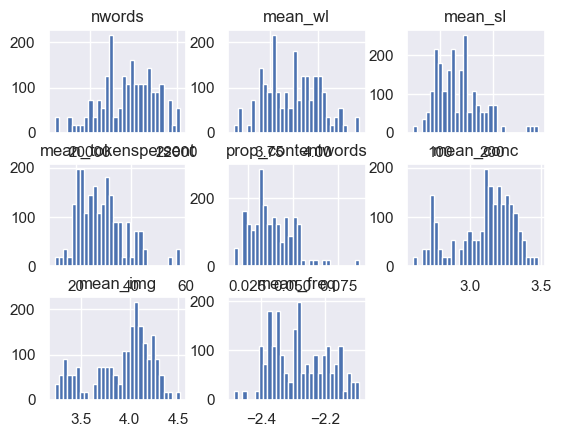

In [4]:
savepath_creative = Path("./results/creative.parquet")

if savepath_creative.exists():
    creative_df = pd.read_parquet(savepath_creative)
else:
    from nltk.corpus import gutenberg

    creative_fns = [file for file in gutenberg.fileids()]
    creative_files = []
    for file in creative_fns:
        listt = split_strings(gutenberg.raw(creative_fns), length=input_length)
        creative_files.extend([(_, file) for _ in listt])

    print(len(creative_files))

    creative_results = process_texts(creative_files)
    
    creative_df = pd.DataFrame(creative_results)

    creative_df.insert(creative_df.shape[1], "class", "PG")

    creative_df.to_parquet(savepath_creative)

creative_df.hist(bins=30)
creative_df.head()


## Loading legal datasets into the pipeline

title  nwords   mean_wl     mean_sl  mean_tokenspersent  \
0  legal_text_0   18053  4.672464  652.601307          118.921569   
1  legal_text_1   17597  4.775530  394.260870           70.438735   
2  legal_text_2   17652  4.777872  422.733051           75.788136   
3  legal_text_3   18013  4.673569  486.809756           88.814634   
4  legal_text_4   17695  4.737157  410.522634           73.522634   

   prop_contentwords  mean_conc  mean_img  mean_freq  \
0           0.008475   3.016673  4.358274  -2.086670   
1           0.014377   2.973358  4.090671  -2.138984   
2           0.013370   3.024933  4.169661  -2.123103   
3           0.011381   2.900618  4.209920  -2.122910   
4           0.013733   2.966905  4.149116  -2.109856   

                                            prop_pos surprisal predictability  \
0  {'ADJ': 0.04204451772464963, 'NOUN': 0.3703215...      None           None   
1  {'ADJ': 0.04578867628079232, 'NOUN': 0.3553672...      None           None   
2  {'ADJ': 0.044727720004472775, 'NOUN': 0.378172...      None           None   
3  {'ADJ': 0.047069808315483054, 'NOUN': 0.373977...      None           None   
4  {'ADJ': 0.050710847419679836, 'NOUN': 0.340814...      None           None   

  class  
0    LG  
1    LG  
2    LG  
3    LG  
4    LG

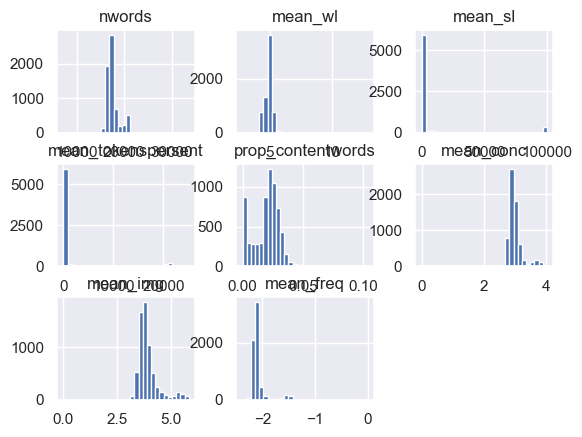

In [5]:
legal_path = Path("./results/legal.parquet")
if legal_path.exists():
    legal_df = pd.read_parquet(legal_path)
else:
    from nltk.corpus import europarl_raw

    legal_texts = read_texts(ds_dgt(), length=input_length)

    europarl_txt = split_strings("".join([" ".join(
        [" ".join(para) for para in chap]) for chap in europarl_raw.english.chapters()]), length=input_length)
    legal_texts.extend(europarl_txt)

    legal_results = process_texts(
        [(legal_text, f"legal_text_{i}") for i, legal_text in enumerate(legal_texts)])

    legal_df = pd.DataFrame(legal_results)
    legal_df.insert(legal_df.shape[1], "class", "LG")

    legal_df.to_parquet(legal_path)


legal_df.hist(bins=30)
legal_df.head()


## Loading writing prompts

title  nwords   mean_wl    mean_sl  mean_tokenspersent  \
0  writingprompts_0   22315  3.571230  72.260806           16.353114   
1  writingprompts_1   22543  3.525352  66.204973           15.162634   
2  writingprompts_2   21895  3.647910  78.745614           17.480861   
3  writingprompts_3   22261  3.595571  68.348821           15.459085   
4  writingprompts_4   22822  3.474805  70.736011           16.406026   

   prop_contentwords  mean_conc  mean_img  mean_freq  \
0           0.061170   3.228014  3.993187  -2.329676   
1           0.066007   3.219386  3.998758  -2.332200   
2           0.057273   3.262477  4.073366  -2.325790   
3           0.064777   3.160694  4.004470  -2.298397   
4           0.061081   3.277664  4.056539  -2.368900   

                                            prop_pos surprisal predictability  \
0  {'ADJ': 0.07839799301137891, 'NOUN': 0.2622076...      None           None   
1  {'ADJ': 0.07720946724581154, 'NOUN': 0.2616346...      None           None   
2  {'ADJ': 0.07668445782582911, 'NOUN': 0.2682815...      None           None   
3  {'ADJ': 0.08038758298941324, 'NOUN': 0.2839583...      None           None   
4  {'ADJ': 0.07861827721906428, 'NOUN': 0.2662877...      None           None   

  class  
0    WP  
1    WP  
2    WP  
3    WP  
4    WP

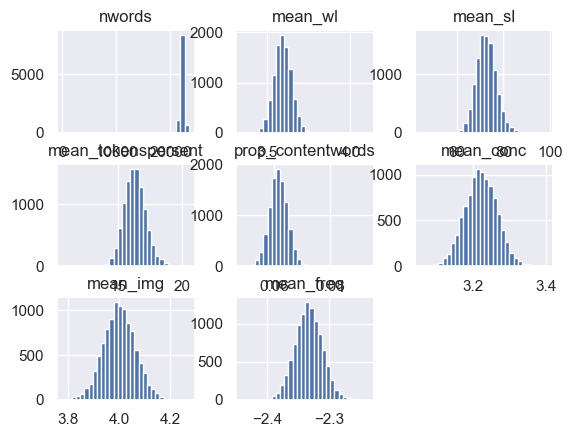

In [6]:
wp_savepath = Path("./results/wp.parquet")
if wp_savepath.exists():
    writingprompts_df = pd.read_parquet(wp_savepath)
else:
    # TODO: Possibly try out stuff like actually splitting the writingprompts dataset instead of reading continuous text.

    wp_path = ds_writingprompts()
    writingprompts = read_texts(wp_path["train"][1], length=input_length)
    writingprompts.extend(read_texts(wp_path["test"][1], length=input_length))
    writingprompts.extend(read_texts(wp_path["val"][1], length=input_length))
    
    # Length (100_000 chars) = 100089
    print(f"Length of writingprompts dataset: {len(writingprompts)}")
    

    wp_results = process_texts(
        list((_, f"writingprompts_{i}") for i, _ in enumerate(writingprompts)))


    # Whole thing took around 35 minutes on battery charge
    
    writingprompts_df = pd.DataFrame(wp_results)
    writingprompts_df.insert(writingprompts_df.shape[1], "class", "WP")
    
    writingprompts_df.to_parquet(wp_savepath)


writingprompts_df.hist(bins=30)
writingprompts_df.head()


A little visualization of what is happening behind the scenes. It seems like the novels have quite a bit more variety behind them at first glance. 

## Experiment


After running the pipeline, we concatenate the results into a single dataframe which we can then use for further analysis. 

Split               
                 Train  Val      Test
Size of Data      4652  582       581
Accuracy       0.99871  1.0  0.998279
Precision     0.998755  1.0  0.998264
Recall        0.998633  1.0  0.998095
F1-Score      0.998691  1.0  0.998175

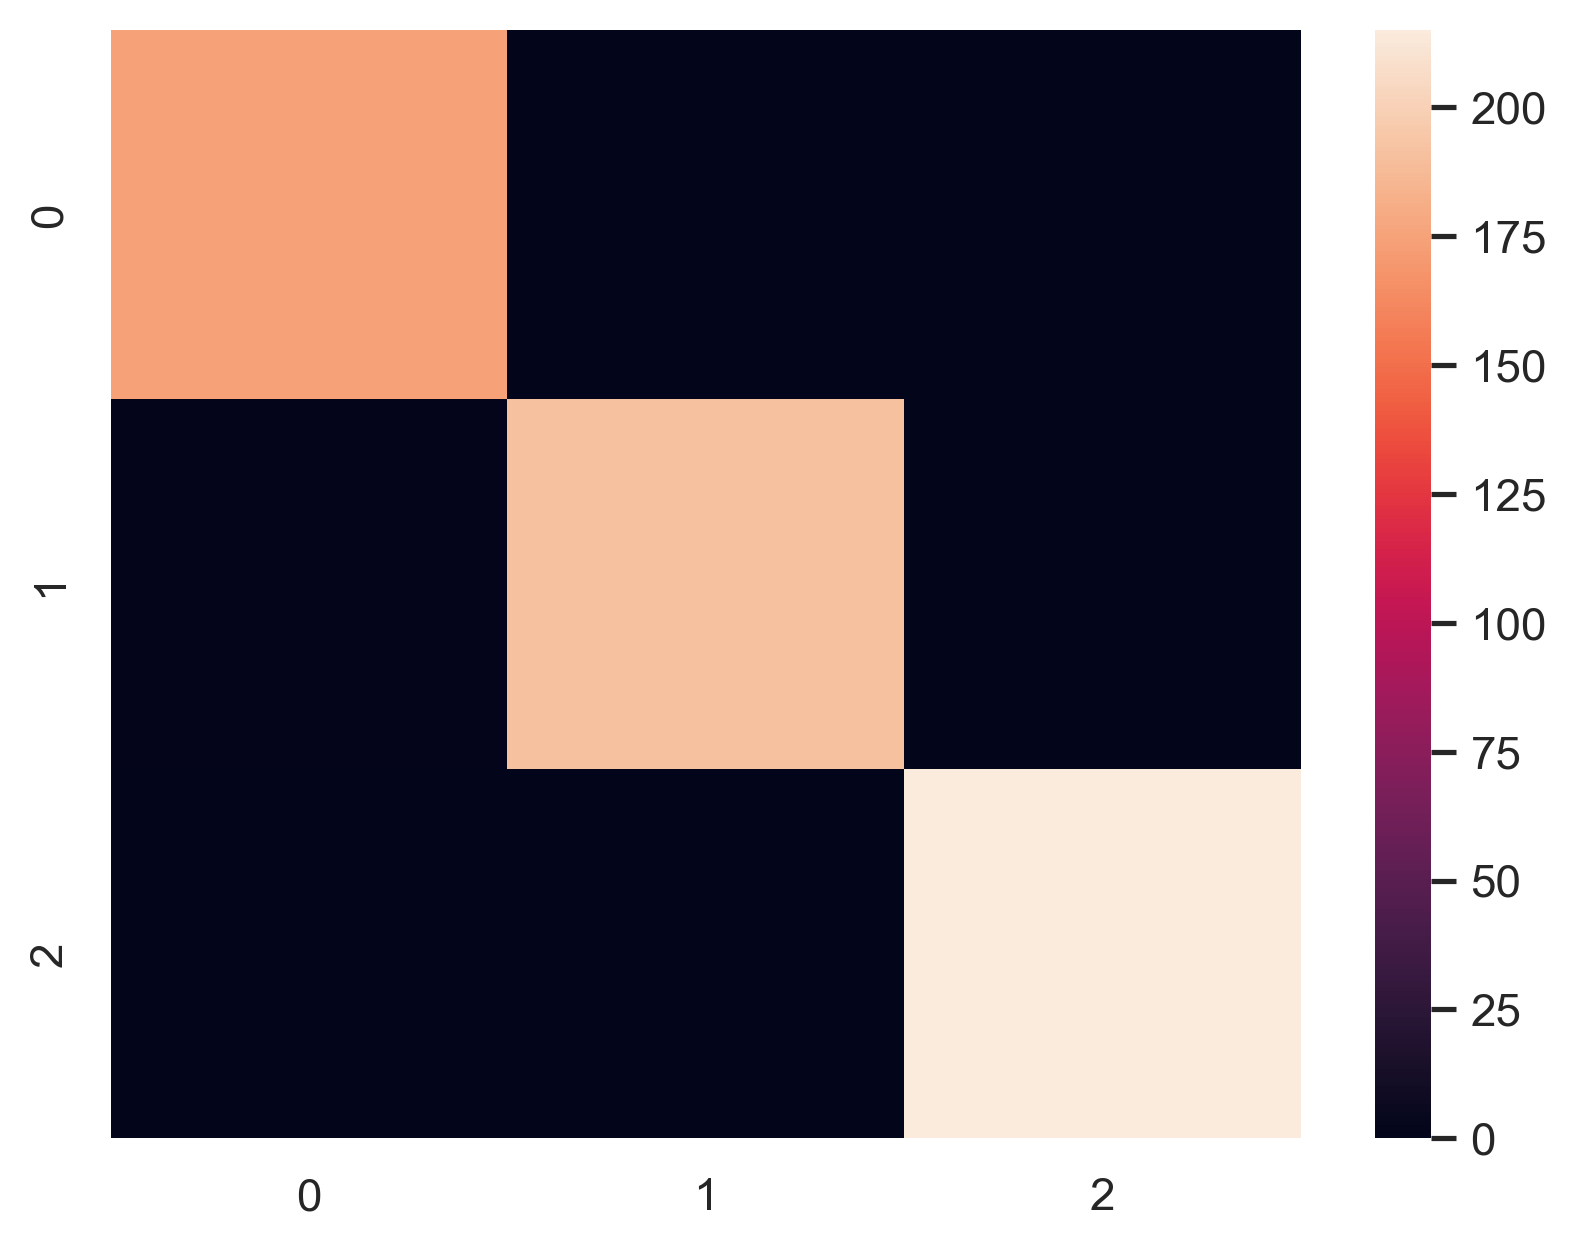

In [7]:
# Join
df = pd.concat([creative_df.head(2000), writingprompts_df.head(
    2000), legal_df.head(2000)], ignore_index=True)
df = df.join(pd.json_normalize(df["prop_pos"]).fillna(0.0))  # type: ignore

df = df.drop(columns=['predictability', 'surprisal'])


df["class"] = df["class"].astype('category')

def remove_outliers(df, deviation: float = 3) -> pd.DataFrame:
    # Remove outliers

    df = df.copy()

    cols = df.select_dtypes('number').columns
    df_sub = df.loc[:, cols]  # type: ignore
    lim = np.abs((df_sub - df_sub.mean()) / df_sub.std(ddof=0)) < deviation

    df.loc[:, cols] = df_sub.where(lim, np.nan)

    return df


df = remove_outliers(df, 3)

# fix bugged sentence length
df["mean_sl"] = df["mean_sl"].where(np.abs(
    (df["mean_sl"] - df["mean_sl"].mean()) / df["mean_sl"].std()) < 0.9, np.nan)

df = df.dropna()

# ####################

# drop unneeded columns and select features
xdf = df.drop(["title", "class", "prop_pos"], axis=1)

# drop arbitrary columns to see how results change
xdf = xdf.drop([
    # "nwords",
    # "mean_wl",
    # "mean_sl",

    #              "NOUN",
    #              "ADJ",
    #             "VERB",
    # "mean_conc", "mean_img", "mean_freq",

    # "prop_contentwords",
    # "mean_tokenspersent"
], axis=1)
ydf = df["class"]

# make the splits
xtrain, xtest, ytrain, ytest = train_test_split(xdf, ydf, train_size=0.8)
xtest, xval, ytest, yval = train_test_split(xtest, ytest, test_size=0.5)

# create the pipeline
model = Pipeline(steps=[("scaler", StandardScaler()),
                 ("logistic", LogisticRegression(max_iter=200))])
split = PredefinedSplit([-1]*len(xtrain)+[0]*len(xval))
params = {'logistic__C': [1/64, 1/32, 1/16,
                          1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64]}
search = GridSearchCV(model, params, cv=split,
                      n_jobs=None, verbose=False, refit=False)
search.fit(pd.concat([xtrain, xval]), pd.concat([ytrain, yval]))
model = model.set_params(**search.best_params_)
model.fit(xtrain, ytrain) 


ptrain = model.predict(xtrain)
pval = model.predict(xval)
ptest = model.predict(xtest)

experiment_dict = {
    'Experiment': 'Document Classification',
    'Size of Data': [
        len(xtrain),
        len(xval),
        len(xtest)
    ],
    'Accuracy': [
        accuracy_score(ytrain, ptrain),
        accuracy_score(yval, pval),
        accuracy_score(ytest, ptest)
    ],
    'Precision': [
        precision_score(ytrain, ptrain, average='macro'),
        precision_score(yval, pval, average='macro'),
        precision_score(ytest, ptest, average='macro')
    ],

    'Recall': [
        recall_score(ytrain, ptrain, average='macro'),
        recall_score(yval, pval, average='macro'),
        recall_score(ytest, ptest, average='macro')
    ],


    'F1-Score': [
        f1_score(ytrain, ptrain, average='macro'),
        f1_score(yval, pval, average='macro'),
        f1_score(ytest, ptest, average='macro')
    ],

}

experiment_df = pd.DataFrame(experiment_dict).T
experiment_df.columns = pd.MultiIndex.from_product(
    [['Split'], ['Train', 'Val', 'Test']])

experiment_df = experiment_df.drop(experiment_df.index[0])

display(experiment_df)

if print_latex:
    print(experiment_df.T.style
          .format(precision=3)
          .to_latex(hrules=True, position_float='centering',

                    # type: ignore
                    label=f'tab:{"_".join(experiment_dict["Experiment"].lower().split())}',
                    caption=f'Performance results for {experiment_dict["Experiment"]}',
                    position='htbp'))


hmap_path = f'./plots/document_classification/heatmap.png'
cmap_aid = plt.subplots(dpi=300)
sns.heatmap(confusion_matrix(model.predict(xtest), ytest), ax=cmap_aid[1])

cmap_aid[0].savefig(hmap_path, bbox_inches='tight')


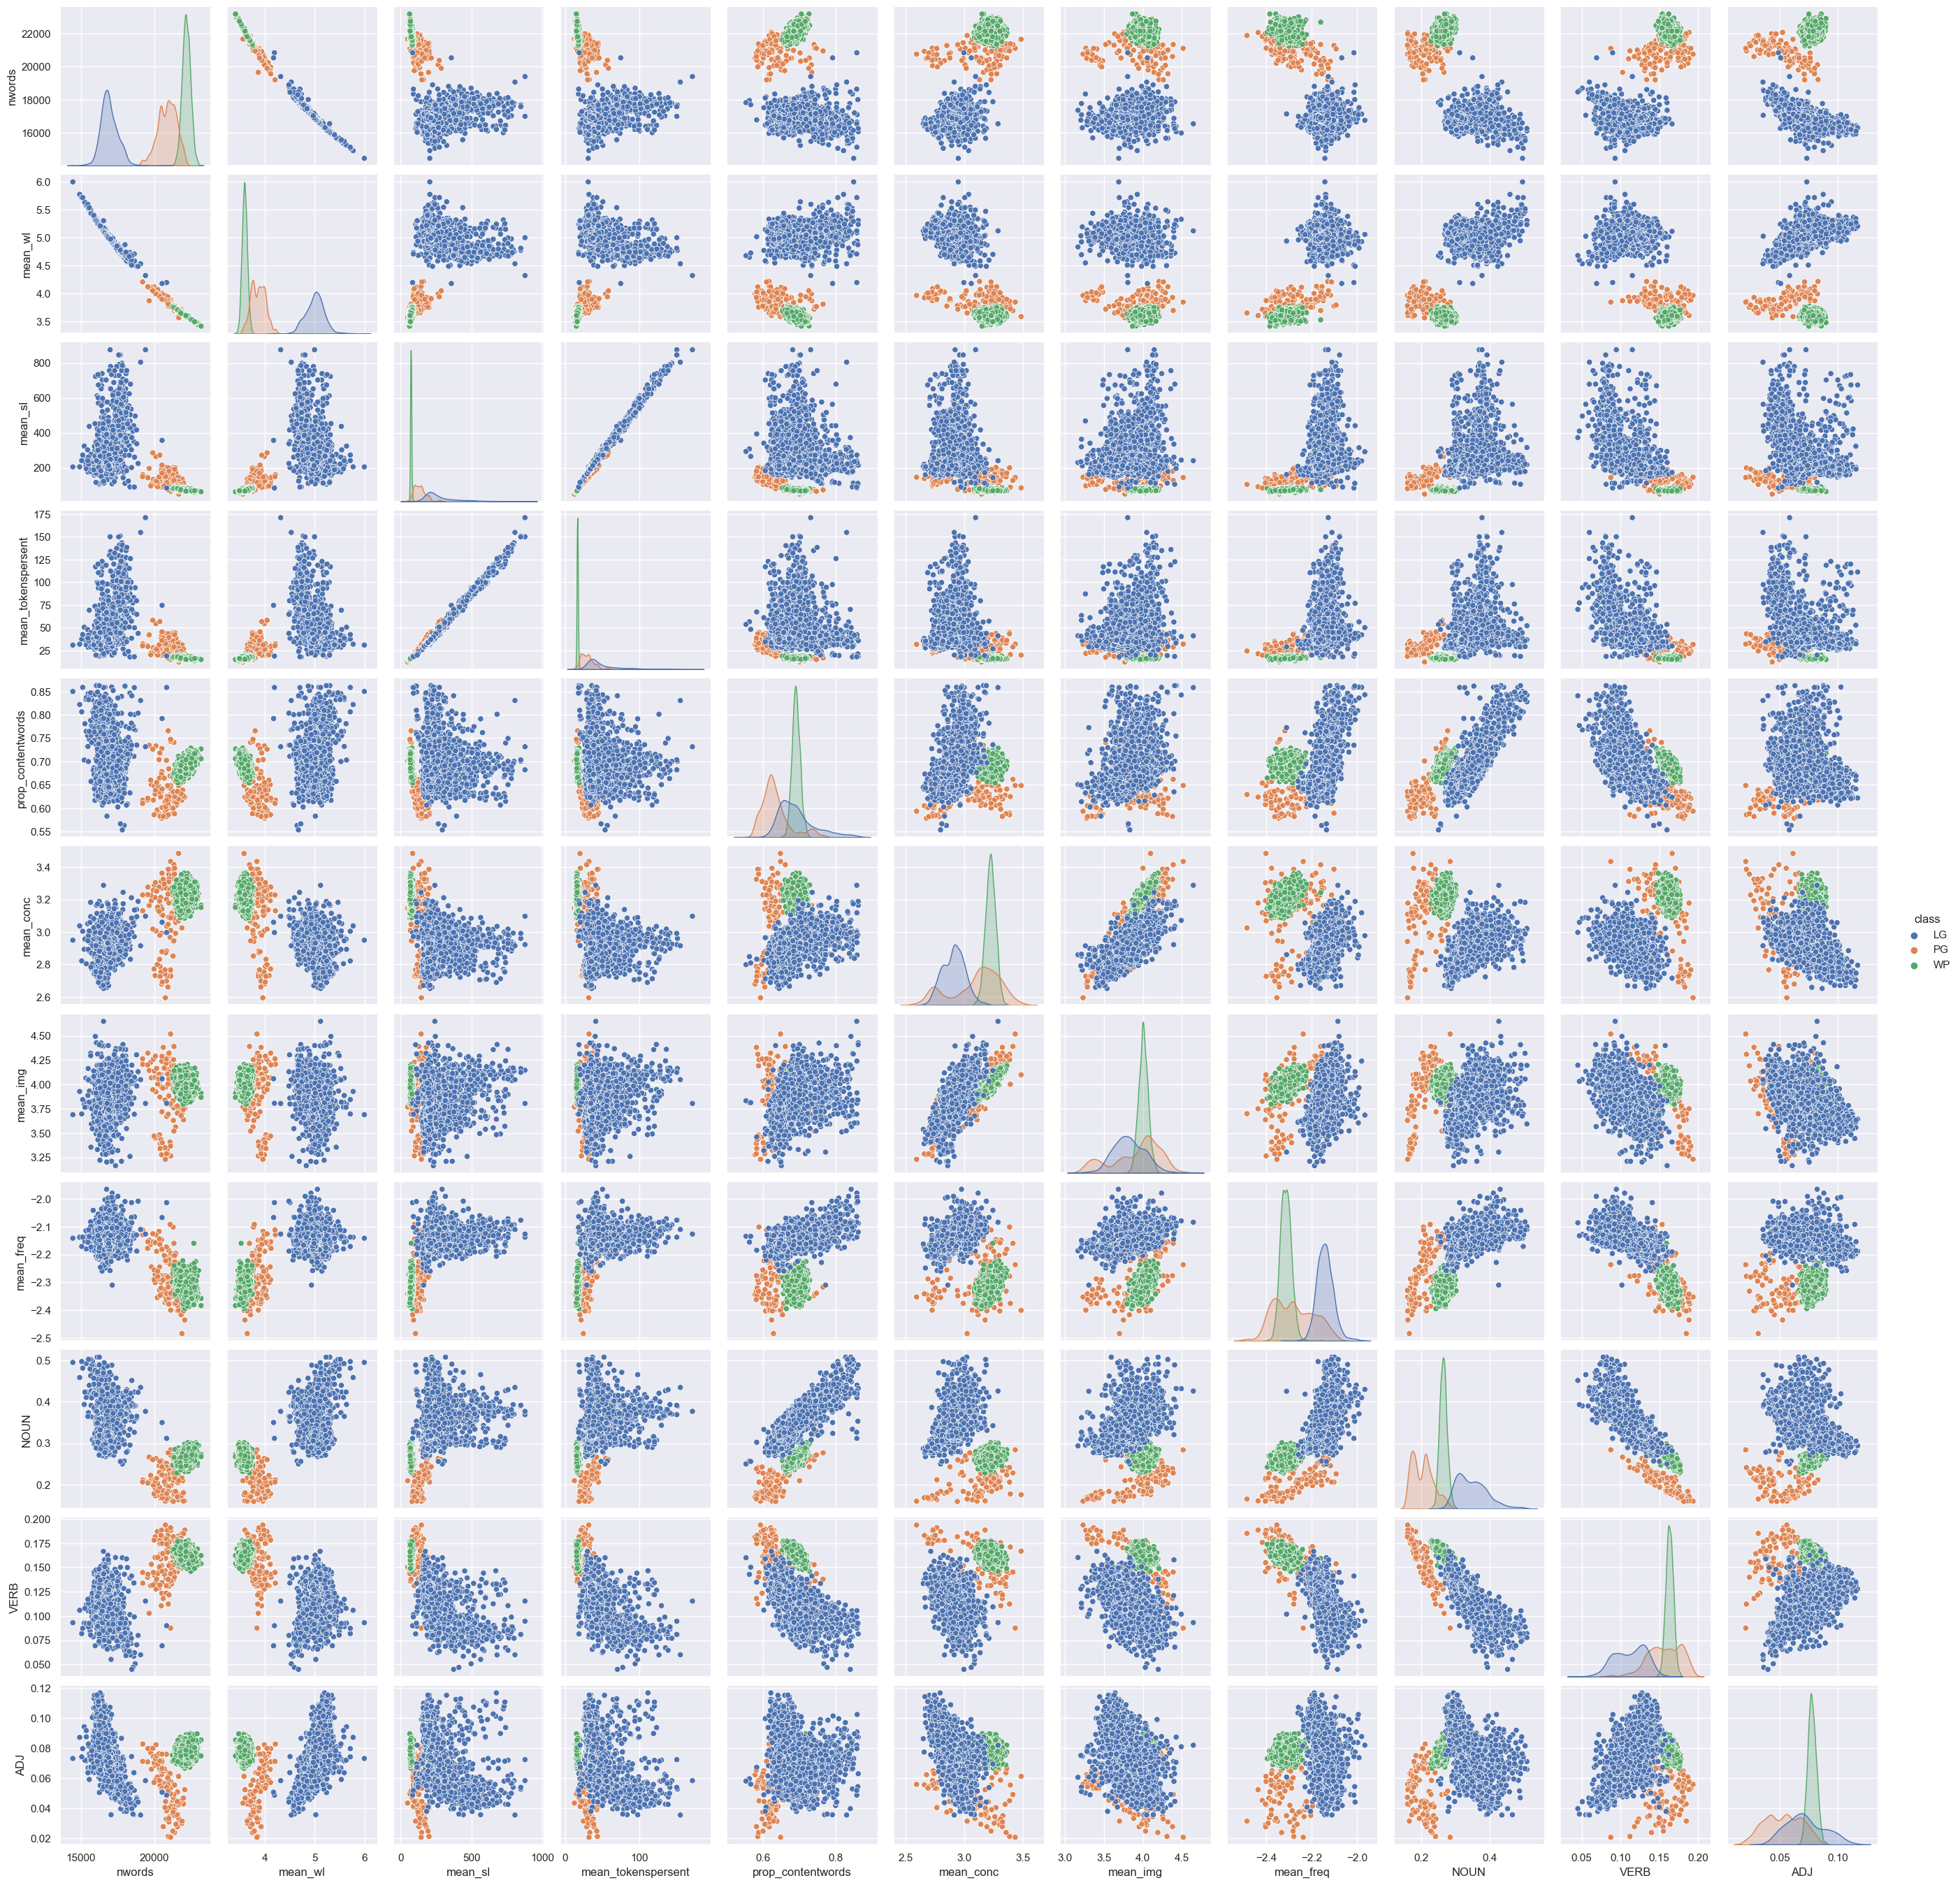

In [275]:
features = df.columns[df.columns.str.contains(
    "title|prop_pos|class") != True].to_list()

g = sns.pairplot(df, hue='class')
g.savefig('./plots/document_classification/big_distplot.png')


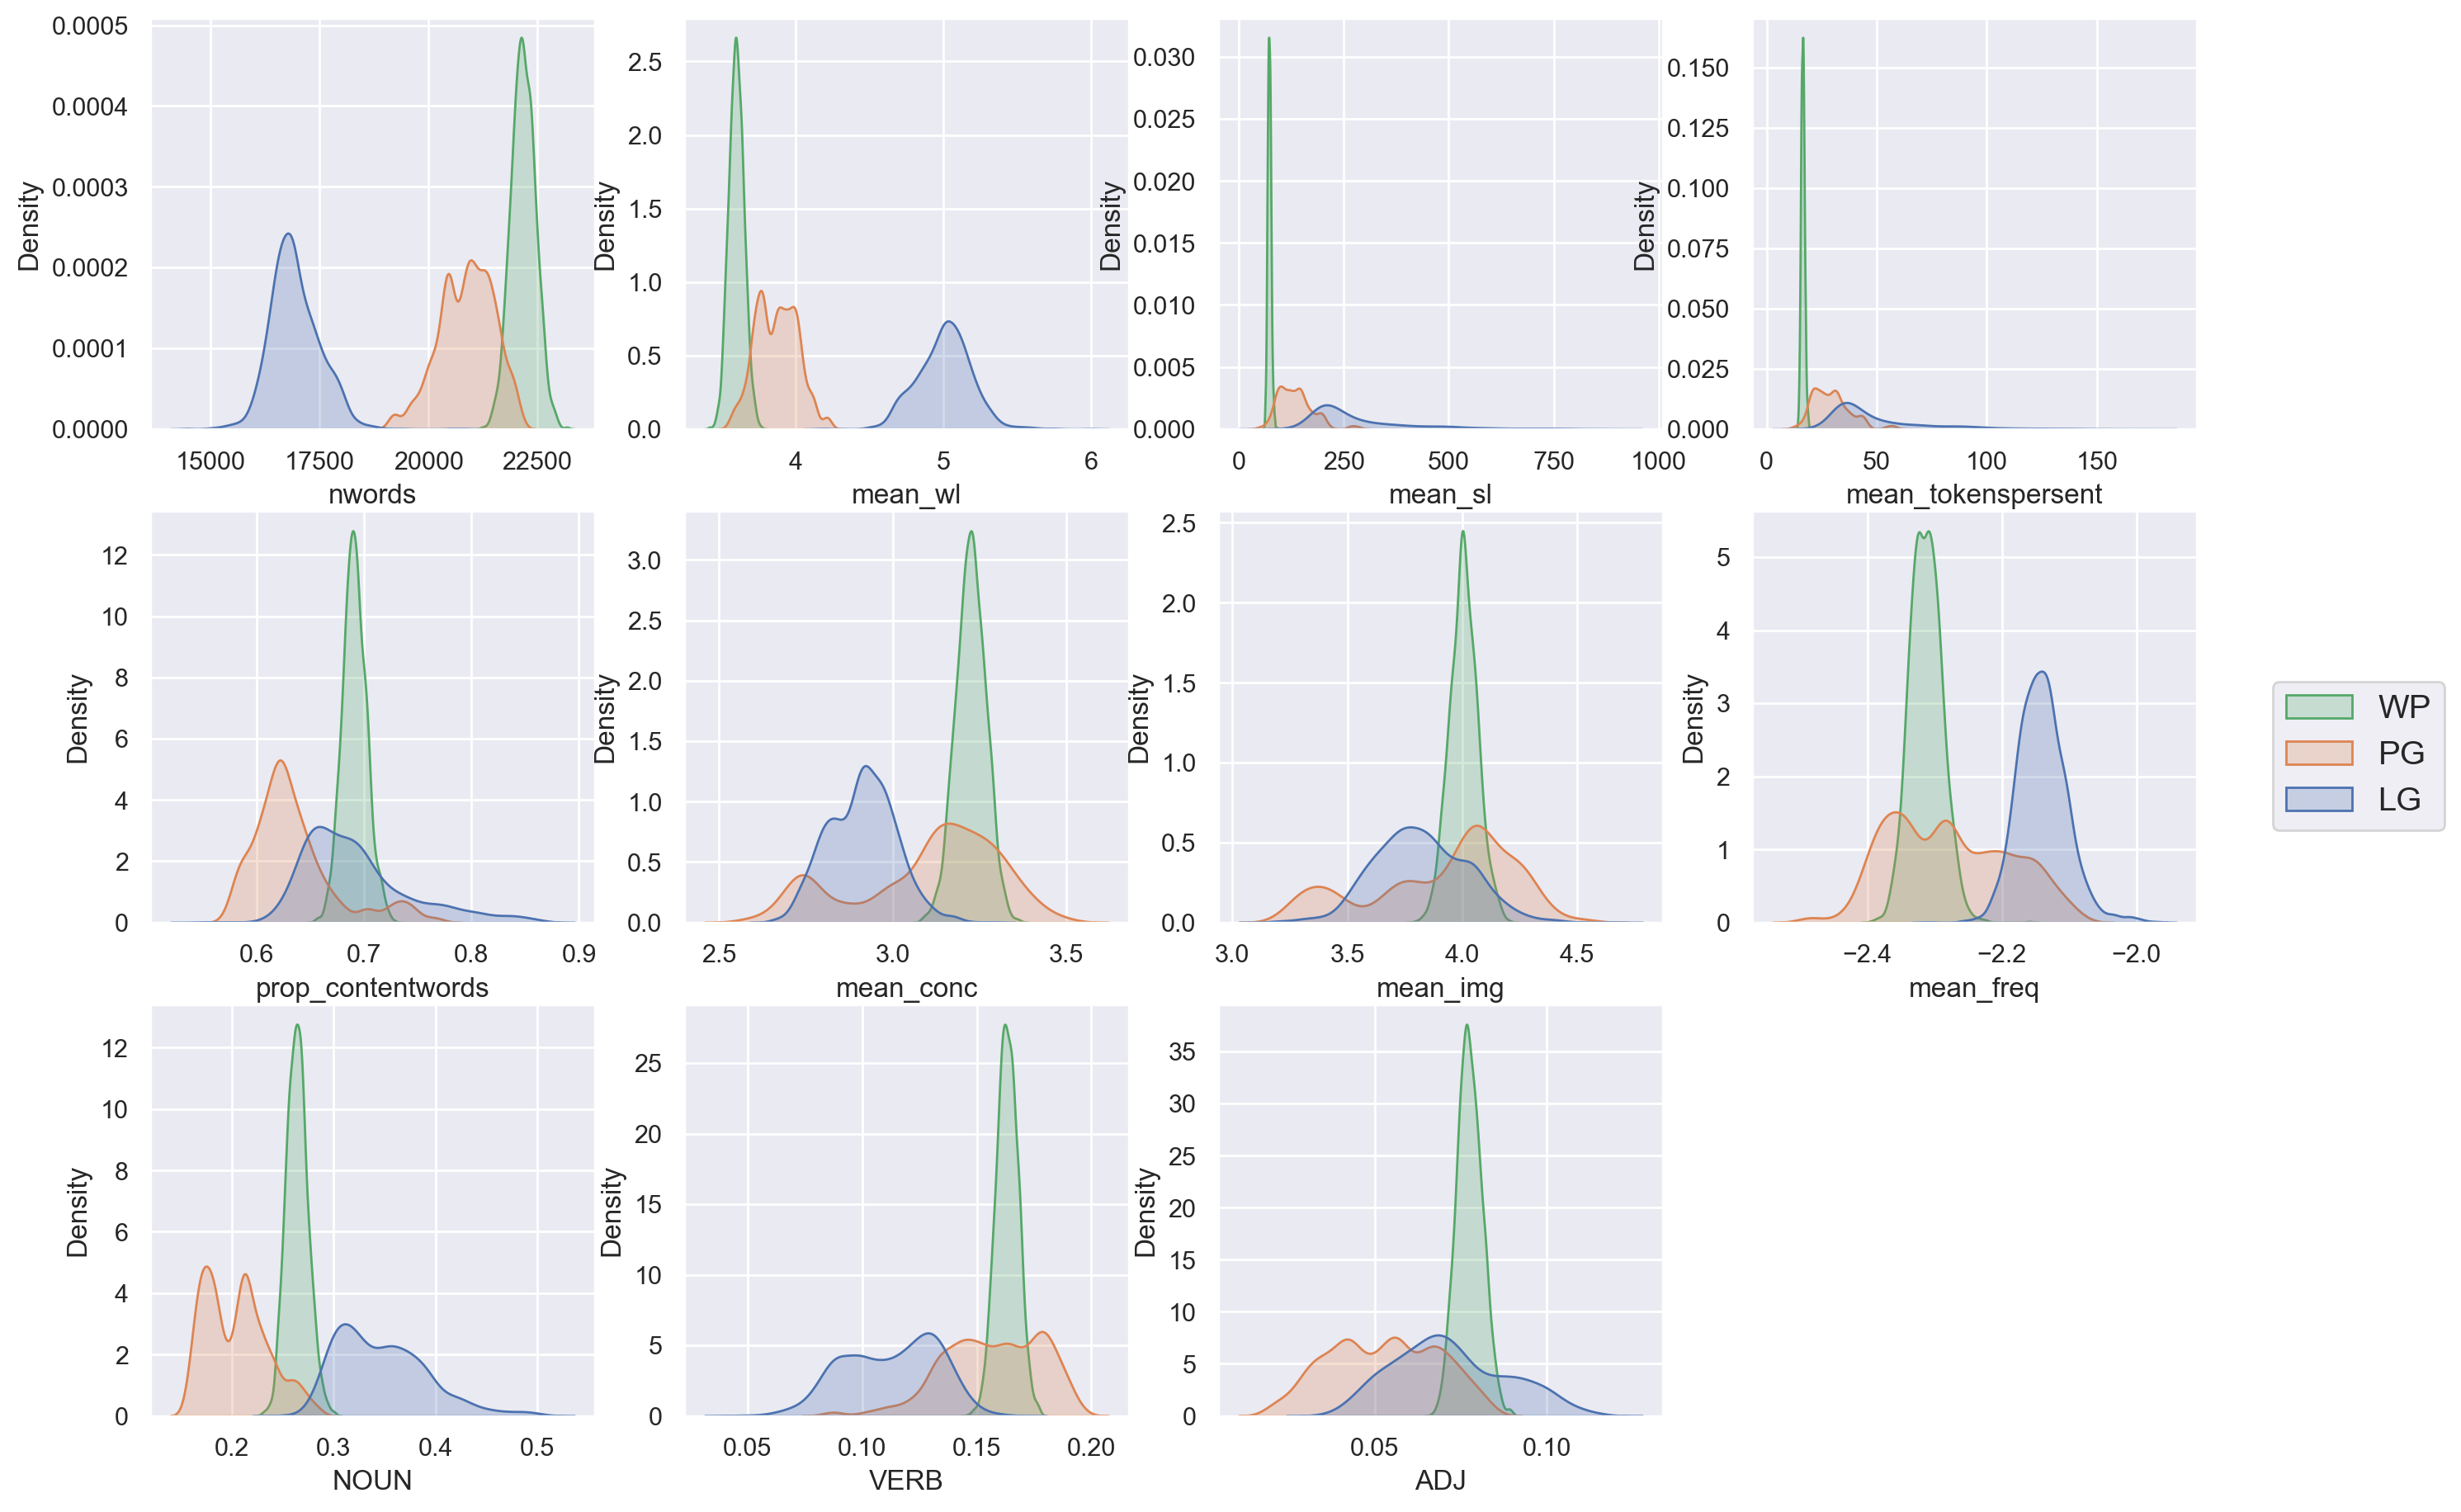

In [274]:
nrows = 3
ncols = 4

fig, axs = plt.subplots(nrows, ncols, figsize=(16, 11), dpi=200)
j = 0
for feature, ax in zip(features, axs.flatten()):
    g = sns.kdeplot(df, x=feature, ax=ax, hue='class', legend=False, fill=True)

# g.legend()
fig.legend(['WP', 'PG', 'LG'], loc='center right', fontsize='large')
axs[-1, -1].axis('off')

fig.savefig('./plots/distplots_classification/data_dist.png')


In [238]:
display_df = pd.DataFrame(
    model.coef_, columns=xdf.columns)  # type: ignore

display_df['categories'] = ydf.cat.categories

display(display_df.T)

# sns.catplot(display_df.T, x='' kind='bar')
# sns.barplot(display_df)
# plt.barh(display_df.index, display_df)


0         1         2
nwords             -0.000437 -0.001373   0.00181
mean_wl             0.727692  5.233776 -5.961468
mean_sl             0.300095 -0.843194  0.543099
mean_tokenspersent -1.347271  4.289867 -2.942597
prop_contentwords   0.153296  0.843964  -0.99726
mean_conc           0.042199 -0.008319  -0.03388
mean_img           -0.021755 -0.428321  0.450076
mean_freq          -0.084391 -1.939098  2.023489
NOUN                0.103735 -0.366002  0.262267
VERB               -0.020825 -0.096662  0.117487
ADJ                -0.007916  -0.38482  0.392736
categories                LG        PG        WP

- Write about lemmatization approaches
- Possibly make a diagram for how the process goes

## Authorship Identification

In [45]:
number_authors = 1000
max_works = 30

# flag to turn on and off if works are to be split into chunks (default behaviour already takes a single chunk of `length` tokens)
chunks = False
pg_authorship_id_path = Path(
    f'./results/pgauthorship_{number_authors}.parquet')

if pg_authorship_id_path.exists():
    pg_df = pd.read_parquet(pg_authorship_id_path)
else:


    def open_pg(id: str):
        with open(f"./gutenberg/data/text/{id}_text.txt") as f:
            return f.read()

    csv = "./gutenberg/metadata/metadata.csv"
    pg = pd.read_csv(csv)

    authors = pg.groupby(['author'], group_keys=True).count(
    ).sort_values(by=['id'], ascending=False)['id']
    authors = authors.loc[authors.index.str.contains(
        r"Various|Anonymous|Unknown") != True]
    print(f"Uniquely identified authors in Project Gutenberg: {len(authors)}\n" +
          f"Uniquely identified pieces of literature: {len(pg)}")

    texts = {}
    for author in authors.index[:number_authors]:
        texts[author] = []
        for i, book in enumerate(list(pg.loc[pg["author"] == author].itertuples())):
            if i > max_works:
                break
            texts[author].append(book.id)

    # for book in list(pg.itertuples())[:5]:
    #     print(book)
    filesnf = 0
    processing_set = []
    for author, collection in texts.items():
        for text in collection:
            try:
                if not chunks:
                    processing_set.append(
                        (open_pg(text)[:100_000], f"{text}_{author}"))
                else:
                    for i, t in enumerate(split_strings(open_pg(text), length=input_length)):
                        processing_set.append((t, f"{text}_{i}_{author}"))
            except FileNotFoundError:
                filesnf += 1

    print(f"Files not found: {filesnf}")
    print(f"Total files: {sum(len(i) for i in texts.values())}")

    results = process_texts(processing_set)

    pg_df = pd.DataFrame(results)
    pg_df.insert(pg_df.shape[-1], "class", [_[-1]
                 for _ in pg_df["title"].str.split('_')])
    pg_df = pg_df.join(pd.json_normalize(
        pg_df["prop_pos"]).fillna(0.0))  # type: ignore

    pg_df.to_parquet(pg_authorship_id_path)

pg_df


title  nwords   mean_wl     mean_sl  mean_tokenspersent  \
0        PG100   20965  3.704031  185.218147           41.245174   
1       PG1041   21347  3.606408  173.742701           39.598540   
2       PG1045   12547  3.604686  197.547945           43.732877   
3      PG10606   20935  3.742393  100.152107           22.399794   
4       PG1100   18213  4.025531   64.788130           13.389234   
...        ...     ...       ...         ...                 ...   
19224  PG55638   15535  4.750821  119.795890           22.178082   
19225  PG56645   18426  4.462064   89.742701           17.608577   
19226  PG58154   18197  4.525691  160.088853           30.290792   
19227  PG60199    2035  4.447174   59.226519           12.154696   
19228  PG60771   19659  4.178442   85.203463           17.837229   

       prop_contentwords  mean_conc  mean_img  mean_freq  \
0               0.024708   2.908476  3.732263  -2.223789   
1               0.025671   2.913356  3.749126  -2.208393   
2               0.023272   3.226101  4.136081  -2.137807   
3               0.046477   2.970679  3.711603  -2.289379   
4               0.079559   3.045187  3.886167  -2.177433   
...                  ...        ...       ...        ...   
19224           0.046991   3.162985  4.063754  -1.485245   
19225           0.059481   3.434391  4.249547  -1.449545   
19226           0.034017   3.401192  4.111081  -1.466871   
19227           0.088943   3.687133  3.901370  -1.339858   
19228           0.058752   3.232630  4.092196  -2.224794   

                                                prop_pos  \
0      {'ADJ': 0.08687105078399252, 'NOUN': 0.2649660...   
1      {'ADJ': 0.09004608294930876, 'NOUN': 0.2788018...   
2      {'ADJ': 0.0783868441660141, 'NOUN': 0.26906812...   
3      {'ADJ': 0.07437485661849048, 'NOUN': 0.2709337...   
4      {'ADJ': 0.05757435183753415, 'NOUN': 0.2797793...   
...                                                  ...   
19224  {'ADJ': 0.1297714638665843, 'NOUN': 0.52303891...   
19225  {'ADJ': 0.1162236385304938, 'NOUN': 0.54272242...   
19226  {'ADJ': 0.11973333333333333, 'NOUN': 0.5293866...   
19227  {'ADJ': 0.09454545454545454, 'NOUN': 0.5522727...   
19228  {'ADJ': 0.06339190369867004, 'NOUN': 0.2398310...   

                        class      NOUN      VERB       ADJ  
0        Shakespeare, William  0.264966  0.153709  0.086871  
1        Shakespeare, William  0.278802  0.146313  0.090046  
2        Shakespeare, William  0.269068  0.145889  0.078387  
3        Shakespeare, William  0.270934  0.125075  0.074375  
4        Shakespeare, William  0.279779  0.147106  0.057574  
...                       ...       ...       ...       ...  
19224  Apollinaire, Guillaume  0.523039  0.072267  0.129771  
19225  Apollinaire, Guillaume  0.542722  0.062957  0.116224  
19226  Apollinaire, Guillaume  0.529387  0.071093  0.119733  
19227  Apollinaire, Guillaume  0.552273  0.047727  0.094545  
19228  Apollinaire, Guillaume  0.239831  0.151247  0.063392  

[19229 rows x 14 columns]

Uniquely identified authors in Project Gutenberg: 22757
Uniquely identified pieces of literature: 70550


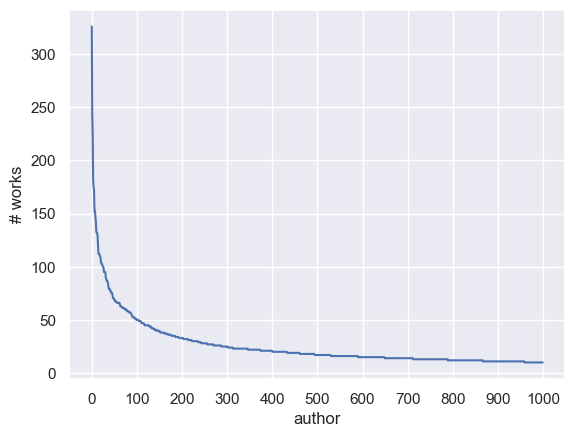

In [42]:
# Distribution:
csv = "./gutenberg/metadata/metadata.csv"
pg = pd.read_csv(csv)

authors = pg.groupby(['author'], group_keys=True).count(
).sort_values(by=['id'], ascending=False)['id']
authors = authors.loc[authors.index.str.contains(
    r"Various|Anonymous|Unknown") != True]
print(f"Uniquely identified authors in Project Gutenberg: {len(authors)}\n" +
        f"Uniquely identified pieces of literature: {len(pg)}")

plt.plot(authors[:1000])
plt.ylabel('# works')
plt.xlabel('author')
plt.xticks(range(0,1001,100),range(0,1001,100));
        

### Pipeline

/Users/Matey/miniconda3/envs/mlkit/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Matey/miniconda3/envs/mlkit/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

Split                    
                 Train       Val      Test
Size of Data     15383      1923      1923
Accuracy      0.266333  0.229329  0.214769
Precision     0.225817  0.147897  0.138563
Recall         0.24712  0.203691  0.186325
F1-Score      0.213652  0.155723  0.140618

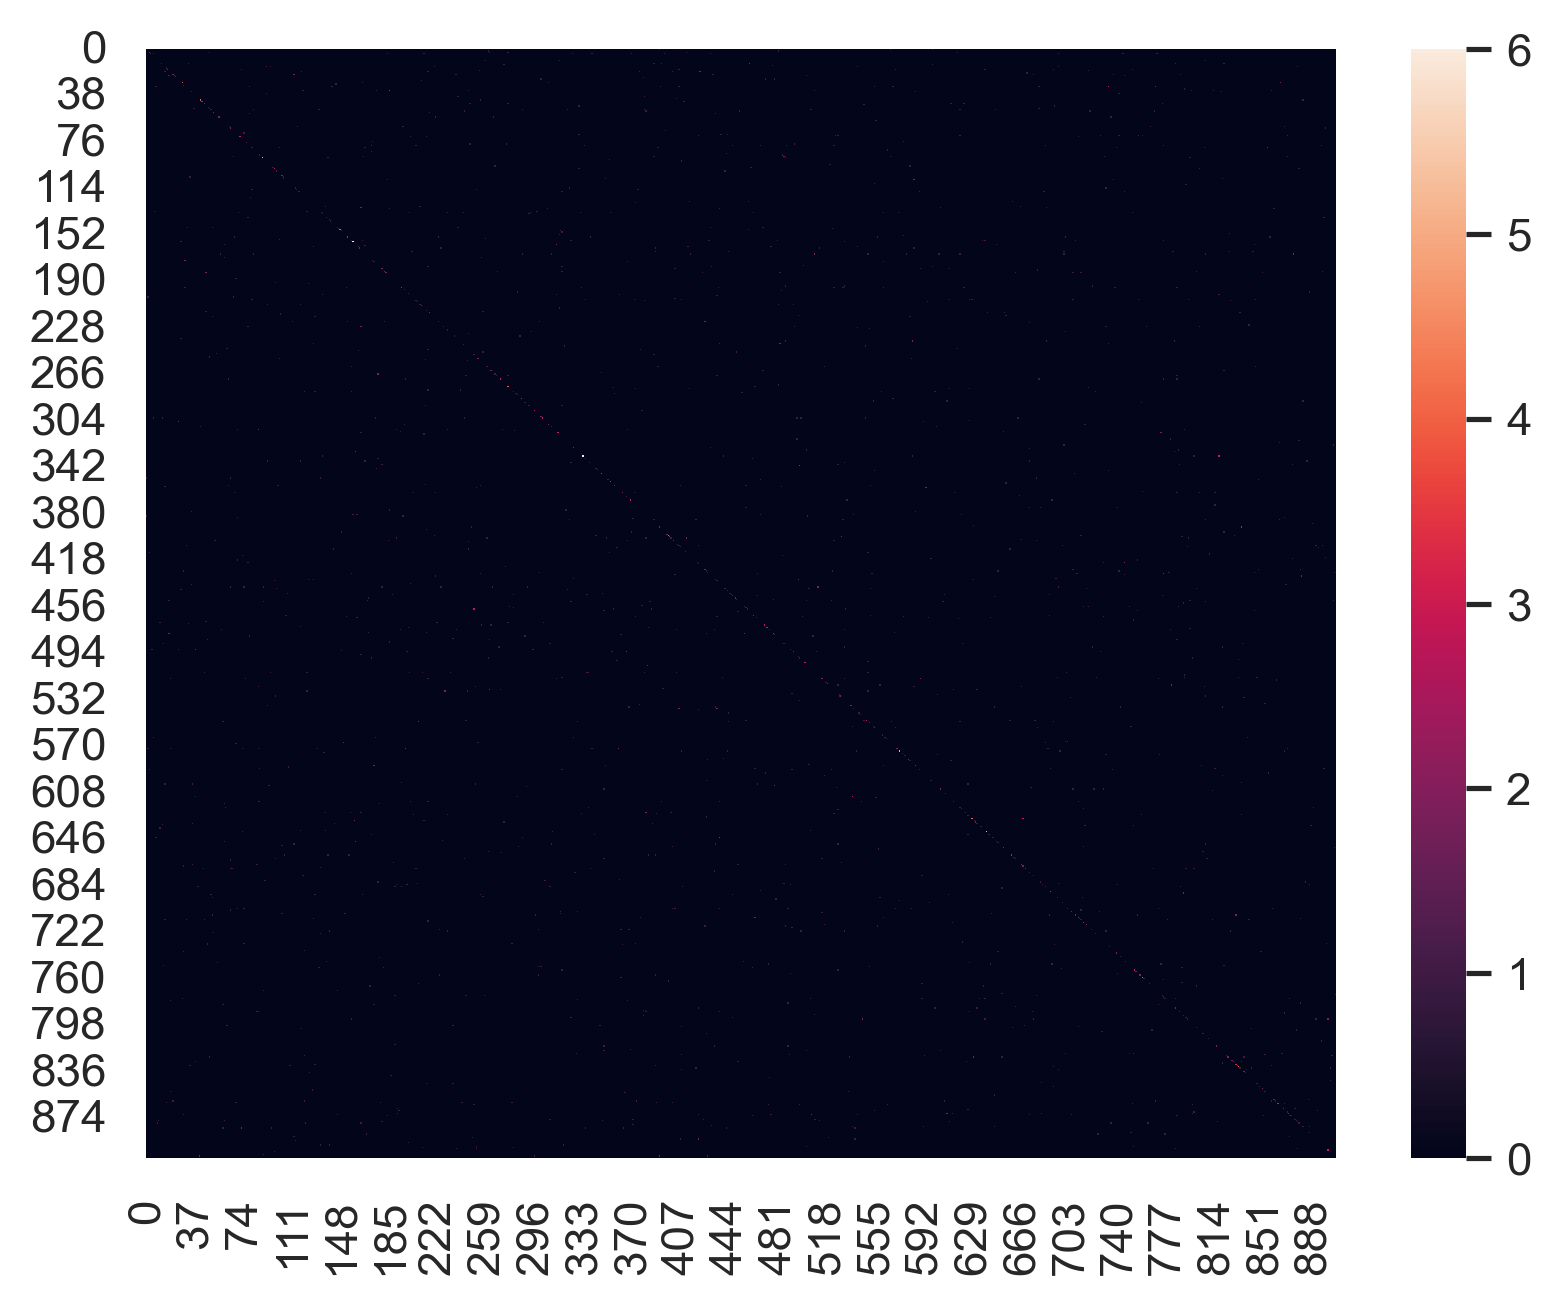

In [46]:
# Join
df = pd.read_parquet(pg_authorship_id_path)

# drop unneeded columns and select features
xdf = df.drop(["title", "class", "prop_pos"], axis=1)

# drop arbitrary columns to see how results change
xdf = xdf.drop([
    # "nwords",
    # "mean_wl",
    # "mean_sl",

    # "NOUN",
    # "ADJ",
    # "VERB",
    # "mean_conc", "mean_img", "mean_freq",

    # "prop_contentwords",
    # "mean_tokenspersent"
], axis=1)
ydf = df["class"]

# make the splits
xtrain, xtest, ytrain, ytest = train_test_split(xdf, ydf, train_size=0.8)
xtest, xval, ytest, yval = train_test_split(xtest, ytest, test_size=0.5)

# create the pipeline
model = Pipeline(steps=[("scaler", StandardScaler()),
                 ("logistic", LogisticRegression(max_iter=200))])
split = PredefinedSplit([-1]*len(xtrain)+[0]*len(xval))
params = {'logistic__C': [1/64, 1/32, 1/16,
                          1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64]}
search = GridSearchCV(model, params, cv=split,
                      n_jobs=None, verbose=False, refit=False)
search.fit(pd.concat([xtrain, xval]), pd.concat([ytrain, yval]))
model = model.set_params(**search.best_params_)
model.fit(xtrain, ytrain)  # apply scaling on training data


ptrain = model.predict(xtrain)
pval = model.predict(xval)
ptest = model.predict(xtest)


experiment_dict = {
    'Experiment': f'Authorship Identification ({number_authors})',
    'Size of Data': [
        len(xtrain),
        len(xval),
        len(xtest)
    ],
    'Accuracy': [
        accuracy_score(ytrain, ptrain),
        accuracy_score(yval, pval),
        accuracy_score(ytest, ptest)
    ],
    'Precision': [
        precision_score(ytrain, ptrain, average='macro'),
        precision_score(yval, pval, average='macro'),
        precision_score(ytest, ptest, average='macro')
    ],

    'Recall': [
        recall_score(ytrain, ptrain, average='macro'),
        recall_score(yval, pval, average='macro'),
        recall_score(ytest, ptest, average='macro')
    ],


    'F1-Score': [
        f1_score(ytrain, ptrain, average='macro'),
        f1_score(yval, pval, average='macro'),
        f1_score(ytest, ptest, average='macro')
    ],

}

experiment_df = pd.DataFrame(experiment_dict).T
experiment_df.columns = pd.MultiIndex.from_product(
    [['Split'], ['Train', 'Val', 'Test']])

experiment_df = experiment_df.drop(experiment_df.index[0])

display(experiment_df)

if print_latex:
    print(experiment_df.T.style
          .format(precision=3)
          .to_latex(hrules=True, position_float='centering',

                    # type: ignore
                    label=f'tab:{"_".join(experiment_dict["Experiment"].lower().split())}',
                    caption=f'Performance results for {experiment_dict["Experiment"]}',
                    position='htbp'))

hmap_path = f'./plots/authorship_identification/aid_{number_authors}.png'
cmap_aid = plt.subplots(dpi=300)
sns.heatmap(confusion_matrix(model.predict(xtest), ytest), ax=cmap_aid[1])
cmap_aid[0].savefig(hmap_path, bbox_inches='tight')


In [56]:
# Join

from typing import Literal


dataset_type: Literal['-k40', ""] = "-k40"
model: Literal['xl-1542M', 'small-117M', 'large-762M','medium-345M'] = "xl-1542M"
nsamples = 40_000
mgtresultspath = Path(f'./results/mgt_results_{nsamples}_{model}{dataset_type}.parquet')


if mgtresultspath.exists():
    df_mgtresults = pd.read_parquet(mgtresultspath)
else:

    mgt_paths = load_machinetext()
    mgt = mgt_paths[model + dataset_type][0]
    non_mgt = mgt_paths["webtext"][0]

    with open(mgt) as f:
        mgt = pd.read_json(f, lines=True)

    with open(non_mgt) as f:
        non_mgt = pd.read_json(f, lines=True)

    mgt["class"] = "MGT"
    non_mgt["class"] = "HUMAN"
    df = pd.concat([mgt, non_mgt])
    df = df.reset_index()
    df["class"] = df["class"].astype('category')

    sample = pd.concat([df.loc[df["class"] =='MGT'].sample(nsamples//2), df.loc[df["class"] == 'HUMAN'].sample(nsamples//2)])

    results = process_texts(
        [(sample["text"][i], sample["class"][i]) for i in sample.index])

    df_mgtresults = pd.DataFrame(results)
    df_mgtresults["class"] = df_mgtresults["title"].astype('category')

    df_mgtresults.to_parquet(mgtresultspath)


Split                    
                 Train       Val      Test
Size of Data     32000      4000      4000
Accuracy      0.636188   0.63125     0.646
Precision     0.636293  0.631386  0.645917
Recall        0.636199  0.631332  0.645847
F1-Score      0.636129  0.631231  0.645858

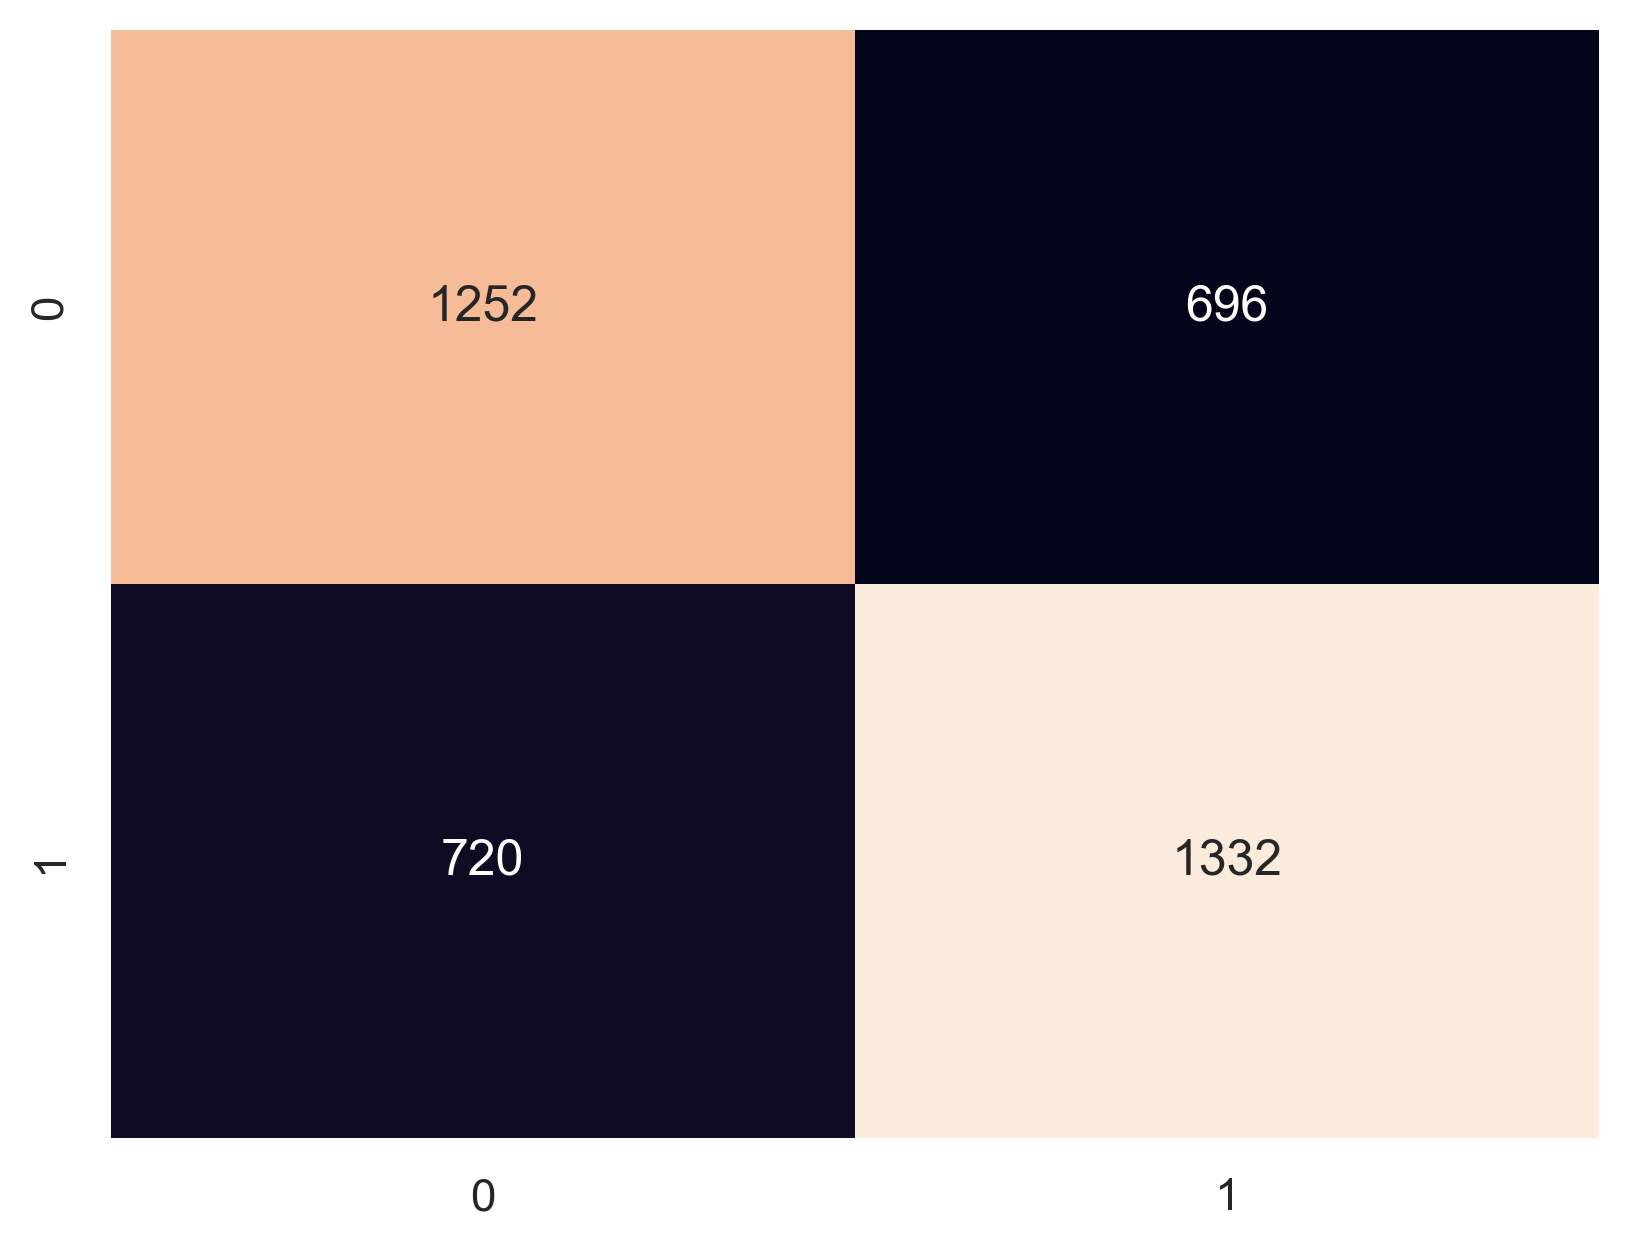

In [55]:
# df = df.reset_index()
df = df_mgtresults

# drop unneeded columns and select features
xdf = df.drop(["title", "class", "prop_pos", "surprisal","predictability"], axis=1)

# drop arbitrary columns to see how results change
xdf = xdf.drop([
    # "nwords",
    # "mean_wl",
    # "mean_sl",

    # "NOUN",
    # "ADJ",
    # "VERB",
    # "mean_conc", "mean_img", "mean_freq",

    # "prop_contentwords",
    # "mean_tokenspersent"
], axis=1)
ydf = df["class"]

# make the splits
xtrain, xtest, ytrain, ytest = train_test_split(xdf, ydf, train_size=0.8, random_state=42)
xtest, xval, ytest, yval = train_test_split(xtest, ytest, test_size=0.5, random_state=42)

# create the pipeline
model = Pipeline(steps=[("scaler", StandardScaler()),
                 ("logistic", LogisticRegression(max_iter=200))])
split = PredefinedSplit([-1]*len(xtrain)+[0]*len(xval))
params = {'logistic__C': [1/64, 1/32, 1/16,
                          1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64]}
search = GridSearchCV(model, params, cv=split,
                      n_jobs=None, verbose=False, refit=False)
search.fit(pd.concat([xtrain, xval]), pd.concat([ytrain, yval]))
model = model.set_params(**search.best_params_)
model.fit(xtrain, ytrain)  # apply scaling on training data

ptrain = model.predict(xtrain)
pval = model.predict(xval)
ptest = model.predict(xtest)

experiment_dict = {
    'Experiment': 'MGT Detection',
    'Size of Data': [
        len(xtrain),
        len(xval),
        len(xtest)
    ],
    'Accuracy': [
        accuracy_score(ytrain, ptrain),
        accuracy_score(yval, pval),
        accuracy_score(ytest, ptest)
    ],
    'Precision': [
        precision_score(ytrain, ptrain, average='macro'),
        precision_score(yval, pval, average='macro'),
        precision_score(ytest, ptest, average='macro')
    ],

    'Recall': [
        recall_score(ytrain, ptrain, average='macro'),
        recall_score(yval, pval, average='macro'),
        recall_score(ytest, ptest, average='macro')
    ],


    'F1-Score': [
        f1_score(ytrain, ptrain, average='macro'),
        f1_score(yval, pval, average='macro'),
        f1_score(ytest, ptest, average='macro')
    ],

}

experiment_df = pd.DataFrame(experiment_dict).T
experiment_df.columns = pd.MultiIndex.from_product(
    [['Split'], ['Train', 'Val', 'Test']])

experiment_df = experiment_df.drop(experiment_df.index[0])

display(experiment_df)

if print_latex:
    print(experiment_df.T.style
        .format(precision=3)
        .to_latex(hrules=True, position_float='centering',
                    
                    # type: ignore
                    label=f'tab:{"_".join(experiment_dict["Experiment"].lower().split())}',
                    caption=f'Performance results for {experiment_dict["Experiment"]}',
                    position='htbp'))

hmap_path = f'./plots/mgt_detection/cmatrix_xl.png'
cmap_aid = plt.subplots(dpi=300)
sns.heatmap(confusion_matrix(model.predict(xtest), ytest,
            labels=ydf.cat.categories.tolist()), ax=cmap_aid[1], annot=True, fmt="g", cbar=False)
cmap_aid[0].savefig(hmap_path, bbox_inches='tight')
